Importing required libraries, mainly tensorflow and keras

In [1]:
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 5
USE_INCEPTION = True

C:\Users\ajulr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ajulr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ajulr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ajulr\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

Preprocessing captions from the dataset

In [3]:
null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()
root_captioning = "flickr8k\Flickr_Data\Flickr_Data"

with open( os.path.join(root_captioning,'Flickr_TextData','Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]  #lowercase all words
      desc = [w.translate(null_punct) for w in desc] # remove punctuations
      desc = [word for word in desc if len(word)>1] #remove small words
      desc = [word for word in desc if word.isalpha()]  #remove all digits
      max_length = max(max_length,len(desc)) #calculate the max length of the caption
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]



Stats on what was collected.

In [4]:
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)


8092
8763
32


Load the Glove embeddings.

In [5]:
img = glob.glob(os.path.join(root_captioning,'Images', '*.jpg'))

Display the count of how many Glove embeddings we have.

In [6]:
len(img)

8091

Read all image names and use the predefined train/test sets.

In [7]:
train_images_path = os.path.join(root_captioning,'Flickr_TextData','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,'Flickr_TextData','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f) 

Display the size of the train and test sets.

In [8]:
print(len(train_images))
print(len(test_images))

6000
1000


Build the sequences.  We include a **start** and **stop** token at the beginning/end.  We will later use the **start** token to begin the process of generating a caption.  Encountering the **stop** token in the generated text will let us know we are done.

In [9]:
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

See how many discriptions were extracted.

In [10]:
len(train_descriptions)

6000

Use Glove for the text embedding and InceptionV3 to extract features from the images.  Both of these transfers serve to extract features from the raw text and the images.  Without this prior knowldge transferred in, this example would take consideraby more training.

In [51]:
if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

The summary for the chosen image neural network to be transfered is displayed.

In [12]:
encode_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
conv2d_1 (

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, 35, 35, 256)  0           activation_5[0][0]               
                                                                 activation_7[0][0]               
                                                                 activation_10[0][0]              
                                                                 activation_11[0][0]              
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 35, 35, 64)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_v1_15 (Batc (None, 35, 35, 64)   192         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_v1_19 (Batc (None, 35, 35, 64)   192         conv2d_19[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1_21 (Batc (None, 35, 35, 64)   192         conv2d_21[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1_24 (Batc (None, 35, 35, 96)   288         conv2d_24[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1_25 (Batc (None, 35, 35, 64)   192         conv2d_25[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 35, 35, 64)   0           batch_normalization_v1_19[0][0]  
__________

batch_normalization_v1_37 (Batc (None, 17, 17, 128)  384         conv2d_37[0][0]                  
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 17, 17, 128)  0           batch_normalization_v1_32[0][0]  
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 17, 17, 128)  0           batch_normalization_v1_37[0][0]  
__________________________________________________________________________________________________
average_pooling2d_3 (AveragePoo (None, 17, 17, 768)  0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 17, 17, 192)  147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_33 

__________________________________________________________________________________________________
batch_normalization_v1_40 (Batc (None, 17, 17, 192)  576         conv2d_40[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1_43 (Batc (None, 17, 17, 192)  576         conv2d_43[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 17, 17, 192)  576         conv2d_48[0][0]                  
__________________________________________________________________________________________________
batch_normalization_v1_49 (Batc (None, 17, 17, 192)  576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 17, 17, 192)  0           batch_normalization_v1_40[0][0]  
__________

activation_59 (Activation)      (None, 17, 17, 192)  0           batch_normalization_v1_59[0][0]  
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, 17, 17, 768)  0           activation_50[0][0]              
                                                                 activation_53[0][0]              
                                                                 activation_58[0][0]              
                                                                 activation_59[0][0]              
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 17, 17, 192)  147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_v1_64 (Batc (None, 17, 17, 192)  576         conv2d_64[0][0]                  
__________

batch_normalization_v1_73 (Batc (None, 17, 17, 192)  576         conv2d_73[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, 17, 17, 192)  0           batch_normalization_v1_73[0][0]  
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 17, 17, 192)  147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 17, 17, 192)  258048      activation_73[0][0]              
__________________________________________________________________________________________________
batch_normalization_v1_70 (Batc (None, 17, 17, 192)  576         conv2d_70[0][0]                  
__________________________________________________________________________________________________
batch_norm

activation_83 (Activation)      (None, 8, 8, 384)    0           batch_normalization_v1_83[0][0]  
__________________________________________________________________________________________________
batch_normalization_v1_84 (Batc (None, 8, 8, 192)    576         conv2d_84[0][0]                  
__________________________________________________________________________________________________
activation_76 (Activation)      (None, 8, 8, 320)    0           batch_normalization_v1_76[0][0]  
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, 8, 8, 768)    0           activation_78[0][0]              
                                                                 activation_79[0][0]              
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 8, 8, 768)    0           activation_82[0][0]              
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_1[0][0]              
                                                                 activation_93[0][0]              
__________________________________________________________________________________________________
avg_pool (GlobalAveragePooling2 (None, 2048)         0           mixed10[0][0]                    
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


### Creating the Training Set

We we need to encode the images to create the training set.  Later we will encode new images to present them for captioning.

In [13]:
def encodeImage(img):
  # Resize all images to a standard size (specified bythe image encoding network)
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # Convert a PIL image to a numpy array
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # Expand to 2D array
  x = np.expand_dims(x, axis=0)
  # Perform any preprocessing needed by InceptionV3 or others
  x = preprocess_input(x)
  # Call InceptionV3 (or other) to extract the smaller feature set for the image.
  x = encode_model.predict(x) # Get the encoding vector for the image
  # Shape to correct form to be accepted by LSTM captioning network.

  x = np.reshape(x, x.shape[1] )
  return x

We can now generate the training set.  This will involve looping over every JPG that was provied.  Because this can take awhile to perform we will save it to a pickle file.  This saves the considerable time needed to completly reprocess all of the images.  Because the images are processed differently by different transferred neural networks, the output dimensions are also made part of the file name.  If you changed from InceptionV3 to MobileNet, the number of output dimensions would change, and a new file would be created.

In [14]:
train_path = os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Images', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

A similar process must also be performed for the test images.

In [15]:
test_path = os.path.join(root_captioning,"data",f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Images', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

Next we separate the captions that will be usef for training.  There are two sides to this training, the images and the captions.

In [16]:
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

Words that do not occur very often can be misleading to neural network training.  It is better to simply remove such words.  Here we remove any words that occur less than 10 times.  We display what the total vocabulary shrunk to.

In [17]:
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


Next we build two lookup tables for this vocabulary. One idxtoword convers index numbers to actual words to index values.  The wordtoidx lookup table performs the opposit.

In [18]:
idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

Previously we added a start and stop token to all sentences.  We must account for this in the maximum length of captions.

In [19]:
max_length +=2
print(max_length)

34


### Using a Data Generator
takes in 2 inputs( image and partial captions) returns the probability of next words

In [20]:
from tensorflow.keras.preprocessing import sequence
def data_generator2(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0

### Loading Glove Embeddings

In [21]:
glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:23, 17101.83it/s]


Found 400000 word vectors.


### Building the Neural Network

An embedding matrix is built from Glove.  This will be directly copied to the weight matrix of the neural network.

In [22]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector


The matrix makes sense.  It is 1652 (the size of the vocabulary) by 200 (the number of features Glove generates for each word).

In [23]:
embedding_matrix.shape

(1652, 200)

In [24]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
embedding_dim

200

In [26]:
caption_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 

In [27]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

### Train the Neural Network

In [28]:
number_pics_per_bath = 3
steps = len(train_descriptions)/number_pics_per_bath

In [29]:
model_path = os.path.join(root_captioning,"data",f'caption-model.hdf5')
start= time()
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS)):
      steps= int(steps)
      generator = data_generator2(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath

  for i in range(EPOCHS):
      generator = data_generator2(train_descriptions, encoding_train, wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)
    



### Generating Captions
A caption is not generated with one single call to the neural network's predict function.  Neural networks output a fixed-length tensor.  To get a variable length output, such as free-form text, requires multiple calls to the neural network.


In [52]:
def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    print('Greedy Search: ' +final)
    return final

In [53]:
import math
def generateCaptionBeamSearch(photo,k):
    t=k
    new_sentences=[ [START,1.0]]    #array of sentence probability pairs 
    while True:
        
        new_sentences = sorted(new_sentences, key=lambda tup:tup[1])
        
        new_sentences= new_sentences[:k]
#         print(new_sentences)
#         print(' ')
#         print('...........................................................')
        end =True
        
        for x in new_sentences:
            if x[0].split()[-1]!=STOP:
                end=False
                    
                
        if end==True:
            new_sentences = sorted(new_sentences, key=lambda tup:tup[1])
            break
        
        possible_sentences= new_sentences
        new_sentences=[]
        
        
        for x in possible_sentences:
            
            in_text = x[0]
            if in_text.split()[-1]==STOP:
                new_sentences.append(x)
                continue
                
            sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
            sequence = pad_sequences([sequence], maxlen=max_length)
#             print(sequence)
            yhat = caption_model.predict([photo,sequence], verbose=0)
#             print(len(yhat[0]))
            new_probs=[]
            for i in range (len(yhat[0])):
                yhat[0][i]=-np.log(yhat[0][i])
                new_probs.append( [i, x[1] + yhat[0][i]])

            ordered = sorted(new_probs, key=lambda tup:tup[1])
            ordered= ordered[:k]
            for y in ordered:
                if(y[0]!=0):
                    z=in_text +' '+ idxtoword[y[0]]
                    new_sentences.append([z,y[1]])




#     print(new_sentences)
    final = new_sentences[1][0].split()
    final = final[1:-1]
    final = ' '.join(final)
    print('Beam search( k =' +str(t) +') : '+final)
    return final

### Evaluate Performance on Test Data from Flicker8k

The caption model performs relativly well on images that are similar to what it trained on.

1.0
flickr8k\Flickr_Data\Flickr_Data\Images\191003285_edd8d0cf58.jpg


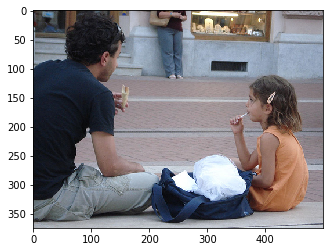

Beam search( k =5) : group of children are sitting on the ground
Greedy Search: two boys are sitting on the ground
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\1917265421_aeccf1ca38.jpg


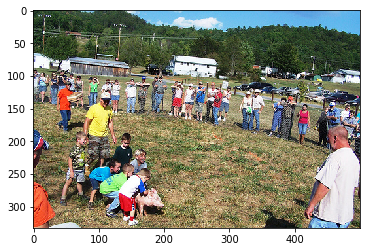

Beam search( k =5) : group of people walking down road
Greedy Search: group of people walk down road
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\1962729184_6996e128e7.jpg


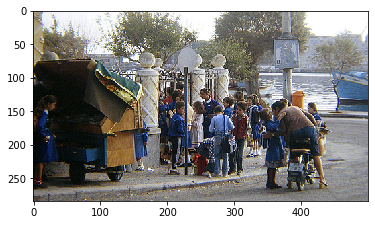

Beam search( k =5) : group of people are standing outside
Greedy Search: two men are standing in front of fountain
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\197107117_4b438b1872.jpg


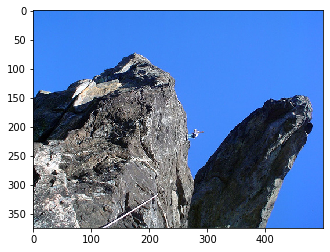

C:\Users\ajulr\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log


Beam search( k =5) : man is standing on top of mountain
Greedy Search: man is climbing rock face
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\197504190_fd1fc3d4b7.jpg


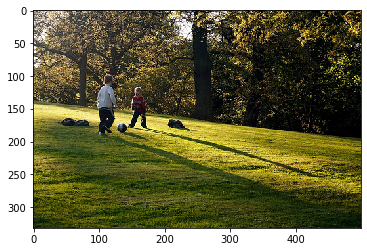

Beam search( k =5) : young boy in red shirt and jeans stands on the grass
Greedy Search: two boys are playing on the grass
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\1982852140_56425fa7a2.jpg


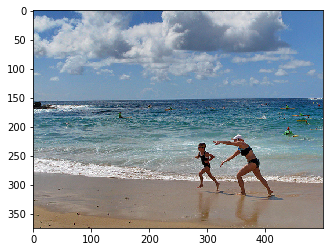

Beam search( k =5) : man is walking on the beach near the ocean
Greedy Search: man in wetsuit is walking on the beach
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\1998457059_c9ac9a1e1a.jpg


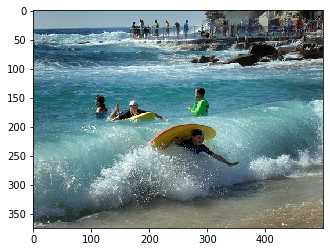

Beam search( k =5) : man in wetsuit is surfing
Greedy Search: man in wetsuit is surfing
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\200771289_31902164a7.jpg


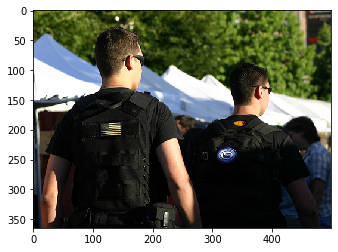

Beam search( k =5) : man with beard and beard is standing in front of crowd
Greedy Search: man in black shirt and hat stands in front of crowd
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2021613437_d99731f986.jpg


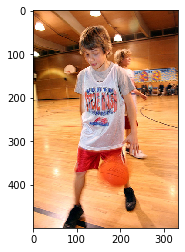

Beam search( k =5) : little boy in red shirt and jeans is playing on trampoline
Greedy Search: two children play on trampoline
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2041867793_552819a40b.jpg


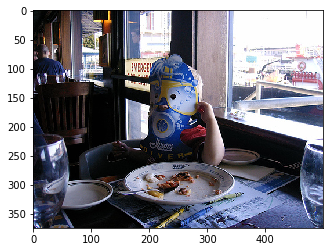

Beam search( k =5) : the man is sitting at the table with his eyes closed
Greedy Search: man in black shirt is sitting on bed with his hand around him
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2049051050_20359a434a.jpg


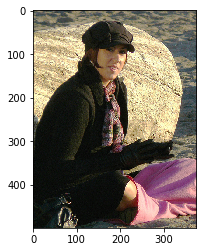

Beam search( k =5) : two people are sitting on rock overlooking the ocean
Greedy Search: man in red shirt is sitting on rock near the ocean
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2054869561_ff723e9eab.jpg


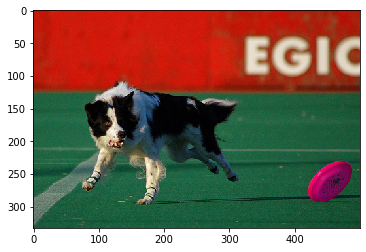

Beam search( k =5) : brown and white dog is running through field
Greedy Search: dog runs through the grass
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2061144717_5b3a1864f0.jpg


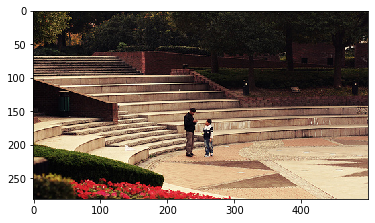

Beam search( k =5) : man and woman are sitting on the edge of fountain
Greedy Search: man in red shirt is walking past houses
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2061354254_faa5bd294b.jpg


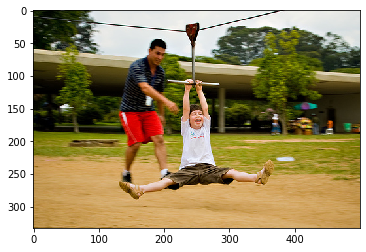

Beam search( k =5) : two boys are playing soccer on field
Greedy Search: two boys are playing soccer on field
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2064790732_219e52e19c.jpg


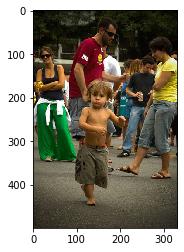

Beam search( k =5) : group of kids are playing on the sidewalk
Greedy Search: two girls are playing on the sidewalk
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2073105823_6dacade004.jpg


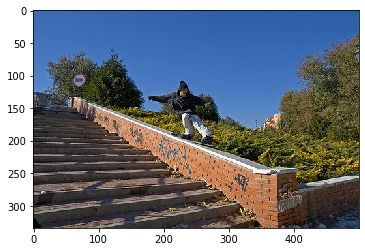

Beam search( k =5) : man is sitting on top of large rock
Greedy Search: man in red shirt is sitting on top of mountain
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2073964624_52da3a0fc4.jpg


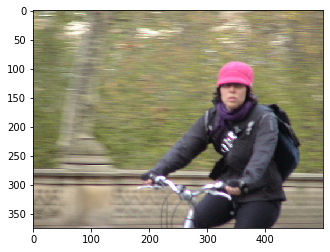

Beam search( k =5) : man is riding bicycle on the street
Greedy Search: man in blue shirt and jeans riding bicycle
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2075321027_c8fcbaf581.jpg


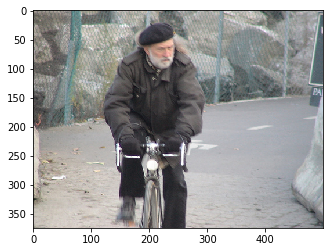

Beam search( k =5) : man and woman are sitting on the side of road
Greedy Search: man in red shirt is walking down the street
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2077079696_03380d218b.jpg


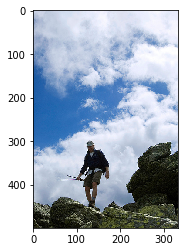

Beam search( k =5) : man is standing on top of rock
Greedy Search: man is climbing up sheer cliff
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2078311270_f01c9eaf4c.jpg


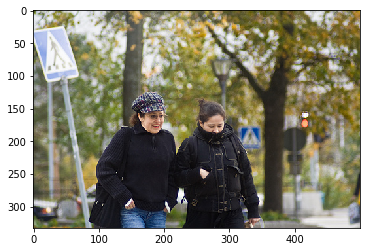

Beam search( k =5) : man in black shirt is walking past
Greedy Search: man in black shirt and jeans stands on street
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2083434441_a93bc6306b.jpg


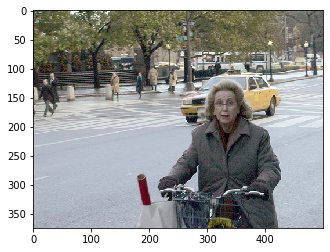

Beam search( k =5) : man in red shirt and jeans is walking past bridge
Greedy Search: man in red shirt and jeans is walking past bridge
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2084217208_7bd9bc85e5.jpg


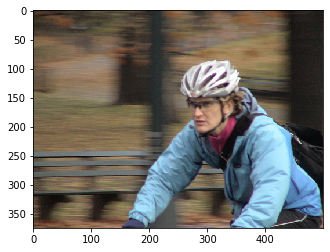

Beam search( k =5) : man and woman are sitting on the street
Greedy Search: man in black shirt and jeans is sitting on bench
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2086513494_dbbcb583e7.jpg


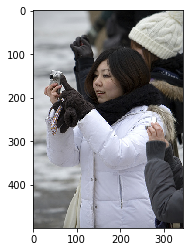

Beam search( k =5) : man and woman are standing in front of store
Greedy Search: man in black shirt and hat stands in front of some trees
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2089426086_7acc98a3a8.jpg


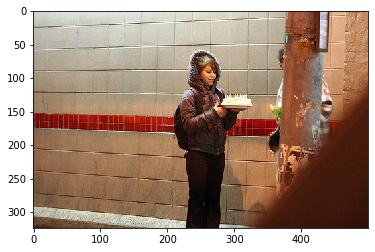

Beam search( k =5) : man and woman are sitting on bench
Greedy Search: man in red shirt is sitting on bench
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2096771662_984441d20d.jpg


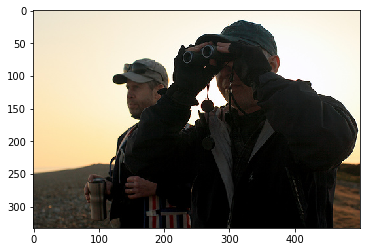

Beam search( k =5) : man in red shirt is sitting on top of mountain
Greedy Search: man in blue shirt is sitting on top of mountain
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2100816230_ff866fb352.jpg


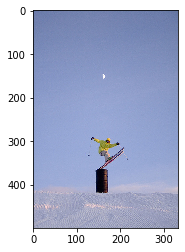

Beam search( k =5) : man is climbing up rock into the water
Greedy Search: man is climbing rock face
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2101457132_69c950bc45.jpg


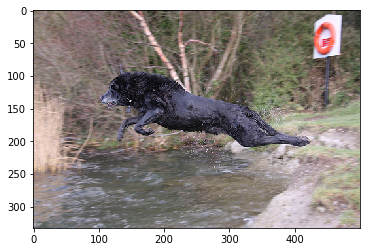

Beam search( k =5) : black dog running through the water
Greedy Search: black dog is running through the water
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2102360862_264452db8e.jpg


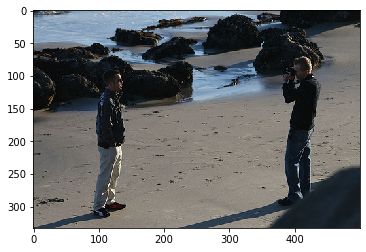

Beam search( k =5) : two people stand on the edge of lake
Greedy Search: two girls are standing on the edge of the ocean
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2103568100_5d018c495b.jpg


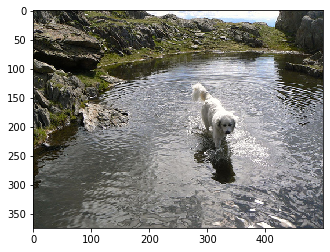

Beam search( k =5) : white dog is running through the water
Greedy Search: dog is walking along the shoreline
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2105756457_a100d8434e.jpg


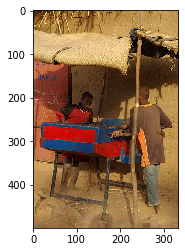

Beam search( k =5) : two children are sitting on the edge of fountain
Greedy Search: two children are playing on the deck of water
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2112921744_92bf706805.jpg


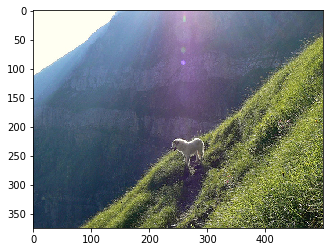

Beam search( k =5) : man is standing on top of mountain
Greedy Search: man is standing on top of mountain
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\211295363_49010ca38d.jpg


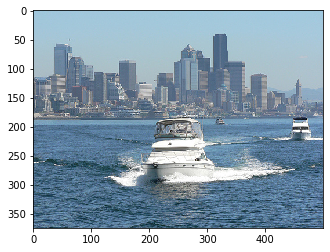

Beam search( k =5) : group of people are sitting on the edge of dock
Greedy Search: man is sitting on the edge of the water with his arms out over the water
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2120383553_5825333a3f.jpg


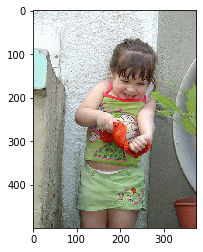

Beam search( k =5) : little boy in red shirt is standing in the grass
Greedy Search: young boy is playing with toy
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2120411340_104eb610b1.jpg


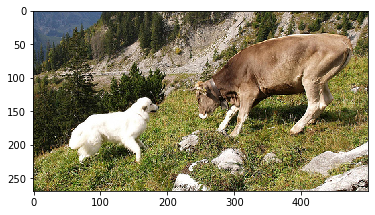

Beam search( k =5) : two dogs are running through the grass
Greedy Search: two dogs are running through the grass
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2124040721_bffc0a091a.jpg


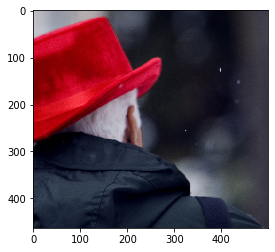

Beam search( k =5) : man with beard and beard is standing next to woman in red jacket
Greedy Search: man in black shirt and hat stands in front of some
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2128119486_4407061c40.jpg


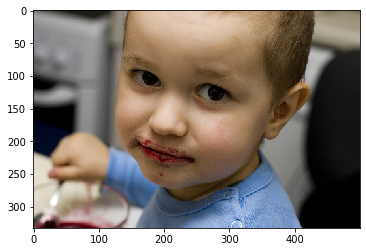

Beam search( k =5) : young boy with his eyes closed
Greedy Search: boy with his eyes closed
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2140182410_8e2a06fbda.jpg


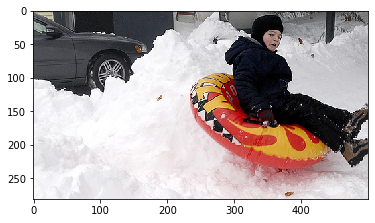

Beam search( k =5) : two children are playing in the snow
Greedy Search: man in red hat and blue hat is sitting in the snow
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2148916767_644ea6a7fa.jpg


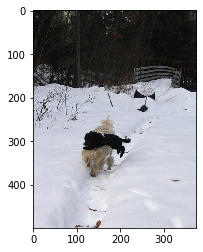

Beam search( k =5) : two dogs playing in the snow
Greedy Search: two dogs are playing in the snow
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\215214751_e913b6ff09.jpg


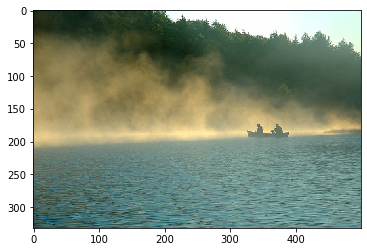

Beam search( k =5) : two people are sitting on the edge of dock
Greedy Search: man is sitting on the edge of dock with his arms out over the water
_____________________________________
flickr8k\Flickr_Data\Flickr_Data\Images\2160266952_a2ab39191b.jpg


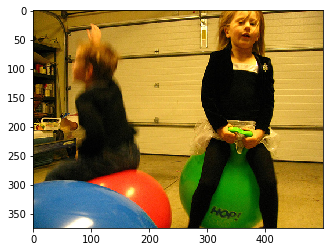

Beam search( k =5) : two girls are sitting on bench
Greedy Search: woman in pink shirt is sitting on the edge of fountain
_____________________________________


In [50]:
from nltk.translate.bleu_score import sentence_bleu
from nlgeval import compute_individual_metrics

reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
candidate = ['this', 'is', 'a', 'test']
score = sentence_bleu(reference, candidate)
print(score)


# print(lookup)
for z in range(100,140):
  
  pic = list(encoding_test.keys())[z]
  #print(lookup[pic[:len(pic)-4]])

  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  print(os.path.join(root_captioning,'Images', pic))
  x=plt.imread(os.path.join(root_captioning,'Images', pic))
  plt.imshow(x)
  plt.show()
#   print("Caption:",generateCaptionbs(image))

  cs= generateCaptionBeamSearch(image,5)
  generateCaption(image)
  references=[]
  score=0
  reference=lookup[pic[:len(pic)-4]]
  for i in reference:
    rs=i.split()
#     mylist = []
#     mylist.append(rs)
#     score= max(score,sentence_bleu(mylist,cs, weights=(1, 0, 0, 0)))
    
    references.append(i)
    
#   metrics_dict = compute_individual_metrics(references,cs)
#   print(metrics_dict)
#   print(score)
  print("_____________________________________")

In [ ]:
caption_model.save_weights("test.hdf5")